# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

Цель лабораторной работы: изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

In [415]:
# импортируем нужные для анализа библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем датасет по типам стекла [Glass Classification](https://www.kaggle.com/datasets/uciml/glass).

In [416]:
# Импортируем датасет
data = pd.read_csv('data/glass.csv', sep=",", thousands=',')
data.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [417]:
# типы колонок
data.dtypes

RI      float64
Na      float64
Mg      float64
Al      float64
Si      float64
K       float64
Ca      float64
Ba      float64
Fe      float64
Type      int64
dtype: object

In [418]:
# Выделяем классифицирующий параметр, делим выборку на обучающую и тестовую
data_target = data.pop("Type")
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(data, data_target, test_size=0.3, random_state=1)

In [419]:
# размер набора данных
data_x_train.shape, data_y_train.shape, data_x_test.shape, data_y_test.shape

((149, 9), (149,), (65, 9), (65,))

In [420]:
type(data_x_train), type(data_y_train)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

# Обучение модели ближайших соседей для фиксированного K

Для начала реализуем вариант модели k ближайших соседей. В качестве метрики расстояния будем использовать евклидово расстояние.

In [421]:
import math
from operator import itemgetter

In [422]:
from enum import Enum
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

In [423]:
class SimpleKNN:
    
    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        """
        Метод обучения, который фактически не учится, 
        а только запоминает обучающую выборку.
        Входные параметры:
        X_train - обучающая выборка (матрица объект-признак)
        y_train - обучающая выборка (вектор целевого признака)
        Возвращаемое значение: нет
        """
        #Сохраняем параметры в переменных класса
        self._X_train = X_train
        self._y_train = y_train
          
    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Вычисление Евклидова расстояния - https://en.wikipedia.org/wiki/Euclidean_distance 
        Входные параметры:
        p, q - вектора в n-мерном пространстве признаков
        """
        return math.sqrt(sum([(pi - qi) ** 2 for pi, qi in zip (p, q)]))
            
            
    def predict_for_single_object(self, K: int, \
                prediction_type: PredictionType, \
                X_o: np.ndarray, \
                verbose = True) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку
            data_train_current_x = [x for x in self._X_train.iloc[i]]
            # и значение ее y
            data_train_current_y = self._y_train[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x)
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x)
            neighbors_list.append(temp_res)
        # *** сортируем список соседей по возрастанию расстояния *** 
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу 
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))

        if verbose:
            print()
            print('**************************************')
            print('Проверяемая точка: ', X_o)
            print('**************************************')
            print('Вывод отсортированного списка соседей:')
            for cur_y, cur_dist, temp_x_1_2 in neighbors_list_sorted:
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
            print()
        
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]

        if verbose:
            print('Вывод К ближайших соседей:')
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                print('y={0}, расстояние={1:.2f}'.format(cur_y, cur_dist))
            print()
        
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)          
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')
                   
    
    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix, 
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)       
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]

In [424]:
# создам объект класса и обучаем модель
simple_knn_clas = SimpleKNN()
simple_knn_clas.fit(data_x_train, data_y_train.to_numpy())

In [425]:
simple_knn_clas._X_train

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
187,1.52315,13.44,3.34,1.23,72.38,0.60,8.83,0.00,0.00
174,1.52058,12.85,1.61,2.17,72.18,0.76,9.70,0.24,0.51
56,1.51215,12.99,3.47,1.12,72.98,0.62,8.35,0.00,0.31
184,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.00,0.00
55,1.51769,12.45,2.71,1.29,73.70,0.56,9.06,0.00,0.24
...,...,...,...,...,...,...,...,...,...
203,1.51658,14.80,0.00,1.99,73.11,0.00,8.28,1.71,0.00
137,1.51711,12.89,3.62,1.57,72.96,0.61,8.11,0.00,0.00
72,1.51593,13.09,3.59,1.52,73.10,0.67,7.83,0.00,0.00
140,1.51690,13.33,3.54,1.61,72.54,0.68,8.11,0.00,0.00


In [426]:
simple_knn_clas._y_train

array([7, 5, 1, 6, 1, 2, 1, 2, 3, 2, 2, 1, 1, 1, 7, 7, 1, 5, 1, 7, 2, 1,
       2, 2, 2, 2, 6, 7, 1, 6, 2, 7, 3, 5, 3, 2, 7, 7, 1, 7, 2, 7, 7, 1,
       2, 2, 1, 5, 7, 5, 2, 2, 7, 5, 7, 2, 1, 2, 5, 1, 2, 2, 3, 1, 6, 5,
       2, 2, 1, 1, 2, 2, 3, 2, 3, 1, 1, 2, 2, 5, 2, 2, 1, 2, 1, 6, 2, 5,
       2, 2, 7, 1, 1, 1, 6, 2, 2, 1, 1, 2, 1, 1, 1, 6, 1, 3, 2, 7, 1, 2,
       5, 2, 7, 1, 1, 2, 1, 1, 1, 1, 1, 1, 7, 2, 2, 2, 1, 1, 2, 3, 3, 2,
       3, 2, 1, 6, 1, 2, 2, 2, 2, 7, 2, 2, 7, 2, 2, 2, 1])

Фаза предсказания в методе ближайших соседей достаточно проста (здесь разобран наиболее простой алгоритм):

Необходимо вычислить расстояние от искомой точки до всех точек обучающей выборки:

Для того, чтобы вычислить расстояние, в пространстве точек необходимо ввести метрику (функцию дистанции).
Наиболее часто используется Евклидова метрика. Для векторов p и q в n-мерном пространстве:
d(p,q)=sqrt((p1−q1)^2+(p2−q2)^2+⋯+(pn−qn)^2)
Также могут использоваться более сложные метрики https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html
Сортируем массив найденных расстояний по возрастанию.

Выбираем K первых элементов массива (соответствующих точкам обучающей выборки, наиболее близких к искомой), знаем Ytrain для этих точек, объединяем найденные Ytrain в массив YKtrain. Таким образом, массив YKtrain - это подмножество вектора Ytrain, соответствующий K точкам обучающей выборки, наиболее близким к искомой точке.
Для полученого массива YKtrain необходимо вычислить регрессию или класификацию:
В случае регрессии берется среднее по всем значениям массива - mean(YKtrain)
В случае классификации возвращается метка класса, наиболее часто встречающегося в YKtrain. То есть мы присоединяем точку к тому классу, к которому уже принадлежит больше всего соседей.
Существуют другие подходы к классификации, например возвращать метку класса для наиболее близкого соседа (в этом случае фактически не учитывается гиперпараметр К).

## Фаза предсказания

In [427]:
# первая строка тестовой выборки
data_test_0 = [x for x in data_x_test.iloc[0]]
data_test_0

[1.52222, 14.43, 0.0, 1.0, 72.67, 0.1, 11.52, 0.0, 0.08]

In [428]:
# построим предсказание для одного объекта (классификация)
simple_knn_clas_0 = simple_knn_clas.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_o=data_test_0)
simple_knn_clas_0


**************************************
Проверяемая точка:  [1.52222, 14.43, 0.0, 1.0, 72.67, 0.1, 11.52, 0.0, 0.08]
**************************************
Вывод отсортированного списка соседей:
y=6, расстояние=0.99
y=6, расстояние=1.30
y=5, расстояние=1.57
y=5, расстояние=1.77
y=2, расстояние=2.04
y=2, расстояние=2.07
y=5, расстояние=2.21
y=2, расстояние=2.53
y=5, расстояние=2.68
y=7, расстояние=2.77
y=7, расстояние=2.85
y=7, расстояние=3.05
y=6, расстояние=3.06
y=5, расстояние=3.06
y=2, расстояние=3.15
y=6, расстояние=3.18
y=7, расстояние=3.19
y=6, расстояние=3.19
y=7, расстояние=3.20
y=7, расстояние=3.21
y=7, расстояние=3.24
y=6, расстояние=3.26
y=5, расстояние=3.27
y=2, расстояние=3.41
y=7, расстояние=3.45
y=5, расстояние=3.50
y=7, расстояние=3.56
y=7, расстояние=3.58
y=7, расстояние=3.61
y=2, расстояние=3.66
y=7, расстояние=3.67
y=7, расстояние=3.69
y=7, расстояние=3.71
y=7, расстояние=3.84
y=2, расстояние=3.86
y=7, расстояние=3.94
y=5, расстояние=3.95
y=1, расстояние=3.96
y=1, ра

5

In [429]:
# Для всех объектов тестовой выборки (классификация)
simple_knn_class_prediction = simple_knn_clas.predict(K=5, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_test=data_x_test)
simple_knn_class_prediction


**************************************
Проверяемая точка:  [1.52222, 14.43, 0.0, 1.0, 72.67, 0.1, 11.52, 0.0, 0.08]
**************************************
Вывод отсортированного списка соседей:
y=6, расстояние=0.99
y=6, расстояние=1.30
y=5, расстояние=1.57
y=5, расстояние=1.77
y=2, расстояние=2.04
y=2, расстояние=2.07
y=5, расстояние=2.21
y=2, расстояние=2.53
y=5, расстояние=2.68
y=7, расстояние=2.77
y=7, расстояние=2.85
y=7, расстояние=3.05
y=6, расстояние=3.06
y=5, расстояние=3.06
y=2, расстояние=3.15
y=6, расстояние=3.18
y=7, расстояние=3.19
y=6, расстояние=3.19
y=7, расстояние=3.20
y=7, расстояние=3.21
y=7, расстояние=3.24
y=6, расстояние=3.26
y=5, расстояние=3.27
y=2, расстояние=3.41
y=7, расстояние=3.45
y=5, расстояние=3.50
y=7, расстояние=3.56
y=7, расстояние=3.58
y=7, расстояние=3.61
y=2, расстояние=3.66
y=7, расстояние=3.67
y=7, расстояние=3.69
y=7, расстояние=3.71
y=7, расстояние=3.84
y=2, расстояние=3.86
y=7, расстояние=3.94
y=5, расстояние=3.95
y=1, расстояние=3.96
y=1, ра

[5,
 7,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 7,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 5,
 6,
 1,
 1,
 1,
 2,
 1,
 1,
 5,
 1,
 1,
 7,
 7,
 1,
 7,
 1,
 1,
 1,
 2,
 7,
 2,
 2,
 1,
 2,
 5,
 2,
 7,
 1,
 1,
 7,
 2,
 6,
 2,
 2,
 1]

# Метрики оценки качества модели

## Accuracy

In [430]:
from sklearn.metrics import accuracy_score
from typing import Dict

Accuracy - процент корректно предсказанных метод класса

In [431]:
accuracy_score(data_y_test, simple_knn_class_prediction)

0.7384615384615385

Вывод значения accuracy для каждого класса по отдельности:

In [432]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [433]:
print_accuracy_score_for_classes(data_y_test, simple_knn_class_prediction)

Метка 	 Accuracy
1 	 0.88
2 	 0.7142857142857143
3 	 0.0
5 	 1.0
6 	 1.0
7 	 0.8888888888888888


Accuracy для классов 5 и 6 составляет 1, они всегда распознавались верно
Accuracy для класса 3 составило 0, этот класс никогда не определялся верно

## Confusion Matrix

В этом методе подсчитываются и показываются в виде матрицы 4 (для бинарной классификации) параметра - верноположительные и верноотрицательные значения, ложноположительные и ложноотрицательные значения.
В случае n классов, параметров n^2

In [434]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [435]:
confusion_matrix(data_y_test, simple_knn_class_prediction, labels=[0, 1, 2, 3, 4, 5, 6, 7])

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 22,  3,  0,  0,  0,  0,  0],
       [ 0,  3, 15,  0,  0,  2,  1,  0],
       [ 0,  6,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  8]])

In [436]:
cl1_1 = KNeighborsClassifier(n_neighbors=5)
cl1_1.fit(data_x_train, data_y_train)

KNeighborsClassifier()

/home/mikhail/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


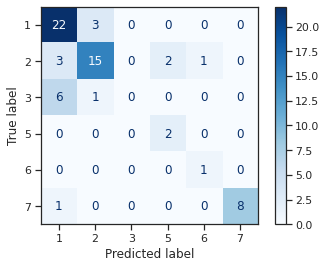

In [437]:
plot_confusion_matrix(cl1_1, data_x_test, data_y_test, cmap=plt.cm.Blues)

/home/mikhail/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


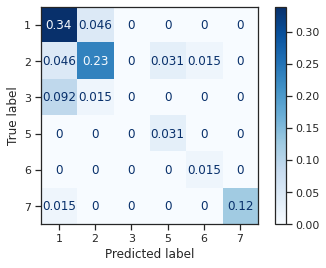

In [438]:
plot_confusion_matrix(cl1_1, data_x_test, data_y_test, cmap=plt.cm.Blues, normalize='all')

## Precision, recall, accuracy

Precision - отношение правильно определённых как положительные объектов по отношению ко всем, определённым как положительные (tp и fp)

Recall - отношение правильно определённых как положительные объектов по отношению ко всем, действительно положительным (tp и fn)

Accuracy - отношение правильно определённых объектов по отношению ко всем

In [439]:
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, f1_score, classification_report

In [440]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется средневзвешенное значение, дисбаланс классов учитывается 
# в виде веса классов (вес - количество истинных значений каждого класса).
precision_score(data_y_test, simple_knn_class_prediction, average='weighted'), \
    recall_score(data_y_test, simple_knn_class_prediction, average='weighted'), \
        balanced_accuracy_score(data_y_test, simple_knn_class_prediction) 

/home/mikhail/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.6810222672064777, 0.7384615384615385, 0.7471957671957673)

F-мера - среднее геометрическое (произведение поделенное на сумму) precision и recall

In [441]:
f1_score(data_y_test, simple_knn_class_prediction, average='weighted')

0.7002897515281417

Classification_report - выводит сразу все показатели выборки

In [442]:
classification_report(data_y_test, simple_knn_class_prediction, output_dict=True)

/home/mikhail/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhail/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mikhail/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'1': {'precision': 0.6875,
  'recall': 0.88,
  'f1-score': 0.7719298245614036,
  'support': 25},
 '2': {'precision': 0.7894736842105263,
  'recall': 0.7142857142857143,
  'f1-score': 0.7500000000000001,
  'support': 21},
 '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7},
 '5': {'precision': 0.5,
  'recall': 1.0,
  'f1-score': 0.6666666666666666,
  'support': 2},
 '6': {'precision': 0.5,
  'recall': 1.0,
  'f1-score': 0.6666666666666666,
  'support': 1},
 '7': {'precision': 1.0,
  'recall': 0.8888888888888888,
  'f1-score': 0.9411764705882353,
  'support': 9},
 'accuracy': 0.7384615384615385,
 'macro avg': {'precision': 0.5794956140350878,
  'recall': 0.7471957671957673,
  'f1-score': 0.6327399380804953,
  'support': 65},
 'weighted avg': {'precision': 0.6810222672064777,
  'recall': 0.7384615384615385,
  'f1-score': 0.7002897515281417,
  'support': 65}}

## ROC-кривая

ROC-кривая, абсцисса которой - отношение ложноположительных классификаций к истинно отрицательным, ордината - recall
В идеале проходит через точки (0, 0), (0, 1) и (1, 1)

In [443]:
from sklearn.metrics import roc_curve, roc_auc_score

In [444]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [445]:
# Конвертация целевого признака в бинарный
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

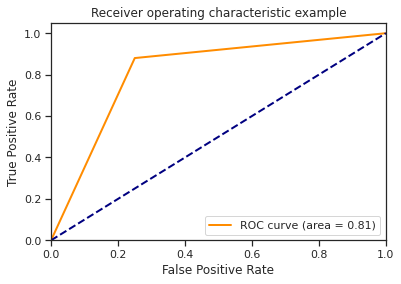

In [446]:
# Выбираем для построения rc-кривой класс 1 (в силу дисбаланса классов в датасете, мультиклассовая roc-кривая получается очень плохой)
bin_data_y_test = convert_target_to_binary(data_y_test, 1)
bin_knn_class_prediction = convert_target_to_binary(simple_knn_class_prediction, 1)

draw_roc_curve(bin_data_y_test, bin_knn_class_prediction, pos_label=1, average='weighted')

## Precision-Recall кривая

In [448]:
y_score = cl1_1.predict_proba(data_x_test)
n_classes = 7

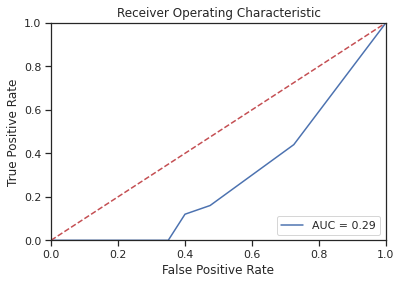

In [451]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = cl1_1.predict_proba(data_x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(data_y_test, preds, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Подбор гиперпараметра K с использованием GridSearch

In [182]:
from sklearn.model_selection import GridSearchCV

In [183]:
n_range = np.array(range(5,55,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
         22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
         39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])}]

In [184]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(data_x_train, data_y_train)

CPU times: user 1.42 s, sys: 0 ns, total: 1.42 s
Wall time: 1.41 s


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54])}],
             scoring='accuracy')

In [185]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00495024, 0.00147223, 0.00136333, 0.00143986, 0.00132661,
        0.00160279, 0.00140901, 0.00126858, 0.00142646, 0.00152597,
        0.00133843, 0.00278616, 0.00136127, 0.0013133 , 0.00125628,
        0.00213647, 0.00268273, 0.00135603, 0.00269122, 0.00344005,
        0.00203009, 0.00138793, 0.00252934, 0.00364838, 0.00374146,
        0.0037869 , 0.00462742, 0.00411534, 0.00130086, 0.00133023,
        0.0014854 , 0.00128684, 0.00148878, 0.00282979, 0.00145907,
        0.00187783, 0.00200729, 0.00190353, 0.00167665, 0.00185213,
        0.00144801, 0.00134821, 0.00131407, 0.00132442, 0.00142975,
        0.00137491, 0.00158086, 0.00231242, 0.0034884 , 0.00384774]),
 'std_fit_time': array([3.12657320e-03, 1.50704910e-04, 1.38031254e-04, 3.30107770e-04,
        5.25444258e-05, 3.92272360e-04, 3.29070101e-04, 4.79851730e-05,
        2.47791539e-04, 2.47586903e-04, 1.22367267e-04, 8.90752386e-04,
        1.49404321e-04, 1.63929763e-04, 1.02412855e-04, 9.87462026e-0

In [186]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(n_neighbors=17)

Лучшая точность получилась у модели 17 ближайших соседей

In [187]:
# Лучшее значение метрики
clf_gs.best_score_

0.6114942528735632

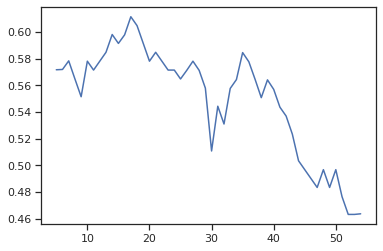

In [188]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])